In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

範例主要參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/cliff_walking.py)

兩個演算法不難看出差異，Q-learning對於$s'$的部份是採取greedy，而Sarsa則是維持著$\epsilon-$greedy

Example 6.6: Cliff Walking
這個gridworld的範例要比較的是Sarsa on-policy與Q-learnin off-policy之間的差異，差異的部份就特別把它highlight出來。這個gridworld長的就像下面這樣：
![](https://i.imgur.com/XyYlEN7.png)
![](https://i.imgur.com/g0D09Fm.png)


這個gridworld的性質如下：
1. undiscount
2. episodic task
3. 有start state與goal state
4. actions有上、下、左、右
5. 每個狀態的轉移reward都-1，除非你進入"The Cliff"的區域，那reward就變-100，然後把你送回起點(綠色線)

上圖呈現的是兩個方法(Sarsa、Q-learnin)使用$\epsilon-$greedy($\epsilon=0.1$)的結果：
* 在[起始瞬變](http://terms.naer.edu.tw/detail/3112801/)之後，Q-learnin就學到optimal policy的value，也就是延著cliff(懸崖)的邊緣在走。不過厚，因為是用$\epsilon-$greedy的方式，所以三不五時還是會掉下去
* Sarsa的話則是將action的選擇列入考慮，走了一條比較長，但是更安全的路

雖然Q-learning確實的學到optimal pylicy的values，但它的online版本的效能真的是比Sarsa的迂迴策略還要來的糟。當然，如果$\epsilon$逐步的調降，那兩個方法都會漸近的收斂到optimal policy。

首先載入需求套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

下面開始設置環境

首先是gridworld的大小

In [3]:
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

公式中的參數

In [4]:
EPSILON = 0.1 # 探索率
ALPHA = 0.5 
DISCOUNT_FACTOR = 1 # GAMMA

定義actions

In [5]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

定義初始狀態(start state)與目標狀態(goal state)

In [6]:
START_STATE = [3, 0]
GOAL_STATE = [3, 11]

定義陷阱區域，掉下來就重來，然後reward - 100

In [7]:
TRAP_AREA = [[3, i] for i in range(1, 11)]
TRAP_AREA

[[3, 1],
 [3, 2],
 [3, 3],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 8],
 [3, 9],
 [3, 10]]

定義step function

這個範例跟6.5的不同在於，有一個區域你掉下去的話，reward是直接扣掉100，所以要特別注意，掉下去之後你的state就直接回到start state

In [8]:
def step(state, action):
    i, j  = state
    if action == ACTION_UP:
        # 避免離開上界，記得取max
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_DOWN:
        # 避免離開下界，記得取min
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    elif action == ACTION_LEFT:
        # 避免離開左邊，記得取max
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        # 避免離開右邊，記得取min
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
        
#     print(f'next_state: {next_state}')
    # 根據範例說明，每一次的移動reward都-1
    # 如果踩到某些區域，那就回到原點，然後reward - 100
    reward = -1
    if next_state in TRAP_AREA:
        reward = -100
        next_state = START_STATE
    
    return next_state, reward

測試一下有踩到陷井跟沒有的狀況

In [9]:
step([0, 0], 1)

([1, 0], -1)

In [10]:
step([2, 10], 1)

([3, 0], -100)

定義一個函數來取action

In [11]:
def action_select(q_values, state):
    """epsilon greedy選擇action
    q_values: value function
    state: current state
    """
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        _values = q_values[state[0], state[1]]
        return np.random.choice([_action for _action, _value in enumerate(_values) if _value == np.max(_values)])

範例比較了Sarsa與Q-learning在學習上的差異，因此我們還需要設置兩個函數

這邊也給出演算法說明

Sarsa
$$Q(S_t,A_t)\leftarrow Q(S_t,A_t) + \alpha[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)] \tag{6.7}$$

Expected Sarsa
$$\begin{align}
Q(S_t, A_t) & \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \mathbb{E}_\pi[Q(S_{t+1}, A_{t+1}) \vert S_{t+1}] - Q(S_t, A_t)] \\
& \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \sum_a \pi(a\vert S_{t+1})Q(S_{t+1}, a)-Q(S_t, A_t)] \tag{6.9}
\end{align}$$

In [12]:
def sarsa(q_values, expected=False, step_size=ALPHA):
    """sarsa algorithm
    q_values: value function
    expected: 是否為expected sarsa，如果是expected sarsa就要計算它的期望值
    step_size: step size，default: ALPHA
    
    這邊定義的是一個episode的計算，
    如果是expected sarsa的話，期望值的計算還會分成best action與非best action
    1-epsilon的機率就是原本best action會出現的機率，如果有多個，那就均分
    epsilon則是所有action會被分配到的機率
    
    """
    state = START_STATE
    action = action_select(q_values, state)
    rewards = 0.0
    
    while state != GOAL_STATE:
        next_state, reward = step(state, action)
        next_action = action_select(q_values, next_state)
        rewards += reward
        
        if not expected:
            target = q_values[next_state[0], next_state[1], next_action]
        else:
            target = 0.0
            # 取得s'的四個action的value
            q_next = q_values[next_state[0], next_state[1], :]
            # 取得最佳action的index
            best_actions = np.argwhere(q_next == np.max(q_next))
            # best與non best action分開計算期望值
            for _action in ACTIONS:
                if _action in best_actions:                    
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) \
                                * q_values[next_state[0], next_state[1], _action]
                else:
                    target += (EPSILON / len(ACTIONS)) * q_values[next_state[0], next_state[1], _action]
        # 乘上GAMMA    
        target *= DISCOUNT_FACTOR
        q_values[state[0], state[1], action] += step_size * (
            reward + target - q_values[state[0], state[1], action]
        )
        state = next_state
        action = next_action
        
    return rewards

下面設置一個計算Q-learning的函數

Q-learning
$$Q(S_t, A_t) \leftarrow Q(S_t,A_t) + \alpha[R_{t+1}+\gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)] \tag{6.8}$$

In [44]:
def q_learning(q_values, step_size=ALPHA):
    """以q learning計算action value"""
    state = START_STATE
    rewards = 0.0
    while state != GOAL_STATE:
        action = action_select(q_values, state)
        next_state, reward = step(state, action)
        rewards += reward
        # 下面以q-learning做更新
        q_values[state[0], state[1], action] += step_size * (
            reward + DISCOUNT_FACTOR * np.max(q_values[next_state[0], next_state[1], :]) - 
                q_values[state[0], state[1], action]
        )
        state = next_state
    
    return rewards

兩個學習演算法都設置好了，可以來執行看看

設置一些參數

In [14]:
episodes = 500
runs = 50

rewards_sarsa = np.zeros(episodes)
rewards_expected_sarsa = np.zeros(episodes)
rewards_q_learning = np.zeros(episodes)

執行演算法，為了比較計算時間，把三個演算法分開來計算好了

In [15]:
%%time
for r in tqdm(range(runs)):
    q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))   
    for i in range(0, episodes):
        rewards_sarsa[i] += sarsa(q_sarsa)

100%|██████████| 50/50 [00:29<00:00,  1.70it/s]

CPU times: user 29.5 s, sys: 440 ms, total: 29.9 s
Wall time: 29.4 s


In [16]:
%%time
for r in tqdm(range(runs)):
    q_expected_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    for i in range(0, episodes):
        rewards_expected_sarsa[i] += sarsa(q_expected_sarsa, True)

100%|██████████| 50/50 [00:42<00:00,  1.16it/s]

CPU times: user 43 s, sys: 124 ms, total: 43.1 s
Wall time: 43 s


In [17]:
%%time
for r in tqdm(range(runs)):
    q_q_learning = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    for i in range(0, episodes):
        rewards_q_learning[i] += q_learning(q_q_learning)

100%|██████████| 50/50 [00:24<00:00,  2.05it/s]

CPU times: user 24.4 s, sys: 152 ms, total: 24.6 s
Wall time: 24.4 s


從這500run的執行結果來看，expected sarsa為了求期望值，它的執行需要的時間是比較常的

In [18]:
# 計算平均
rewards_sarsa /= runs
rewards_expected_sarsa /= runs
rewards_q_learning /= runs

有action-value function就可以決定policy

In [19]:
def policy_control(q_values):
    """列印最佳策略"""
    optimal_policy = []
    for i in range(WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(WORLD_WIDTH):
            if [i, j] == GOAL_STATE:
                optimal_policy[-1].append("G")
                continue
            bestAction = np.argmax(q_values[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
        
    for row in optimal_policy:
        print(row)

In [20]:
policy_control(q_sarsa)

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'D', 'U', 'R', 'U', 'R', 'R', 'R', 'U', 'D', 'D']
['U', 'U', 'R', 'U', 'R', 'U', 'U', 'U', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


In [21]:
policy_control(q_expected_sarsa)

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


In [22]:
policy_control(q_q_learning)

['U', 'R', 'R', 'U', 'R', 'R', 'R', 'R', 'D', 'U', 'D', 'D']
['R', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'D', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


可以看的到，q learning學到的policy就跟書上範例是一致的。在起點往上之後就一路向右直奔終點。

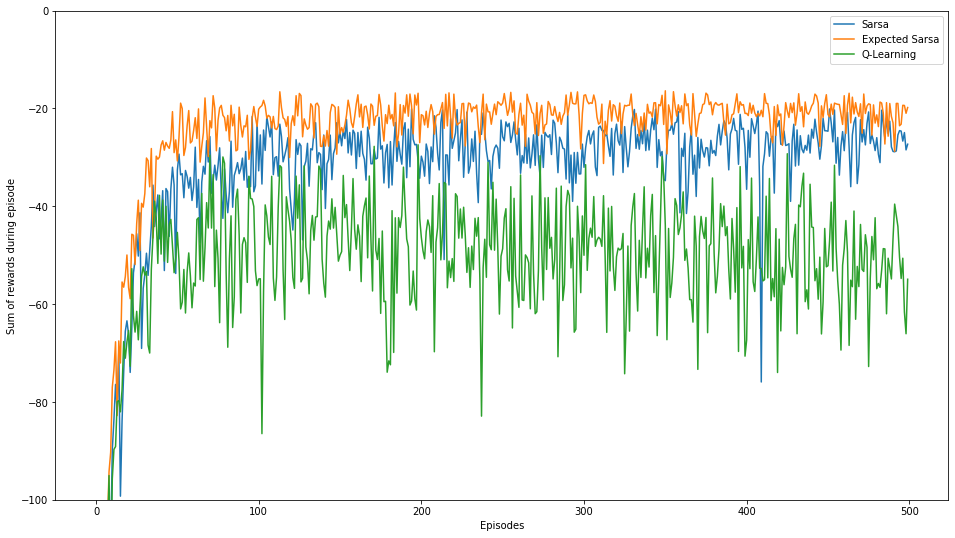

In [25]:
plt.figure(figsize=(16, 9))
plt.plot(rewards_sarsa, label='Sarsa')
plt.plot(rewards_expected_sarsa, label='Expected Sarsa')
plt.plot(rewards_q_learning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()
plt.show()

接著，作者特別提到，因為機器的限制，所以他並沒有完整的根據書本中的範例來實作。不過得到的效果看起來也還可以。

下面範例主要是繪製出Figure 6.3

![](https://i.imgur.com/dTLkbR1.png)
Figure 6.3：TD control methods在cliff-walking task上作為$\alpha$的函數的效能(interim與asymptotic)。所有的演算法都使用$\epsilon-$greedy，且$\epsilon=0.1$。asympotoic performance(漸近效能)是100,000個episodes的平均值，然後interim performance則是前100個episodes的平均。這些資料是interim與asymptotic各別執行500,000個episodes與10runs的平均。實心圓的標記則是每一種方法的最佳interim performancec。改編自van Seijen et al. (2009)。

In [29]:
step_sizes = np.arange(0.1, 1.1, 0.1)
step_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [30]:
episodes = 1000
runs = 10

In [33]:
ASYM_SARSA = 0
ASYM_EXPECTED_SARSA = 1
ASYM_Q_LEARNING = 2
INT_SARSA = 3
INT_EXPECTED_SARSA = 4
INT_Q_LEARNING = 5
# 總共六種方法
methods = range(0, 6)
methods

range(0, 6)

In [41]:
list(zip(range(0, len(step_sizes)), step_sizes))

[(0, 0.1),
 (1, 0.2),
 (2, 0.30000000000000004),
 (3, 0.4),
 (4, 0.5),
 (5, 0.6),
 (6, 0.7000000000000001),
 (7, 0.8),
 (8, 0.9),
 (9, 1.0)]

In [57]:
performance = np.zeros((6, len(step_sizes)))

for run in range(runs):
    for idx, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):
        # 初始化value function
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_expected_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_q_learning = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        
        for episode in range(episodes):
            sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
            expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
            q_learning_reward = q_learning(q_q_learning, step_size=step_size)
            performance[ASYM_SARSA, idx] += sarsa_reward
            performance[ASYM_EXPECTED_SARSA, idx] += expected_sarsa_reward
            performance[ASYM_Q_LEARNING, idx] += q_learning_reward
            
            # interim只記錄前100次
            if episode < 100:
                performance[INT_SARSA, idx] += sarsa_reward
                performance[INT_EXPECTED_SARSA, idx] += expected_sarsa_reward
                performance[INT_Q_LEARNING, idx] += q_learning_reward


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


In [58]:
performance[: 3, :] /= episodes * runs
performance[3: , :] /= 100 * runs

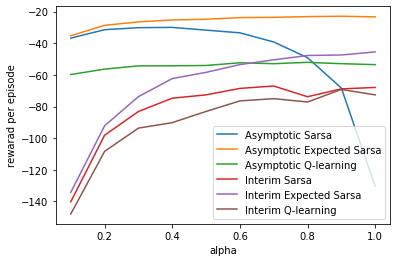

In [59]:
labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-learning', 
          'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-learning']

for method, label in zip(methods, labels):
    plt.plot(step_sizes, performance[method, :], label=label)

plt.xlabel('alpha')
plt.ylabel('rewarad per episode')
plt.legend()
plt.show()
    